Digit Image Recognition Using CNN with MNIST Dataset Test 
1. data preparation
    - load data
    - normalization
    - reshape with 3D
    - label encoding
2. model generation
    - add layers
    - add optimizer
    - callback generation
    - compiler model
3. evaluate the model
    - training models

First of all is to create new kernel. 
And add competition data from the competition or anywhere the data you want.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


import necessary libraries. 

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential                                   # model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D   # layers
from keras.optimizers import RMSprop                                  # optimizer
from keras.preprocessing.image import ImageDataGenerator              
from keras.callbacks import ReduceLROnPlateau                         # callback function

import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))                #list the input folder files

Using TensorFlow backend.


sample_submission.csv
test.csv
train.csv



Load data from input directory which point to the data you added from competition. 
Using shape function we can look the shape of our data. 

In [3]:
# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("../input/train.csv")
test= pd.read_csv("../input/test.csv")
print('train datasets shape: ',train.shape)
print('test datasets shape: ',test.shape)
train.head()

train datasets shape:  (42000, 785)
test datasets shape:  (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In training phase the input data must be non labeled data so we split train data to two part. 


In [5]:
y_label = train["label"]
x_train = train.drop(labels = ["label"], axis =1)
del train
print('x train datasets shape: ',x_train.shape)
print('y label datasets shape: ',y_label.shape)

x train datasets shape:  (42000, 784)
y label datasets shape:  (42000,)


normalize and reshape the data. 
CNN require 3D data and normalization can facilitate training.  

In [6]:
x_train = x_train/255.0
y_label = to_categorical(y_label, 10)
print('x train datasets shape: ',x_train.shape)
print('y label datasets shape: ',y_label.shape)
x_train.head()

x train datasets shape:  (42000, 784)
y label datasets shape:  (42000, 10)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
x_train = x_train.values.reshape(-1, 28, 28, 1)
print('x train datasets shape: ',x_train.shape)

x train datasets shape:  (42000, 28, 28, 1)


Visualize data with matplotlib

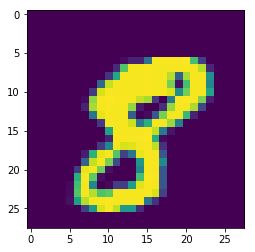

In [8]:
img = plt.imshow(x_train[10][:,:,0])

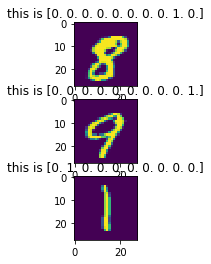

In [9]:
n = [10, 100,1000]
j = 0
for i in n:
    j+=1
    plt.subplot(310+(j))
    plt.imshow(x_train[i][:,:,0])
    plt.title("this is {}".format(y_label[i]))

generate CNN model.

In this test I use an other optimizer function called adam.

And also used callback function to decrease learning rate when the val_acc is not changed in 3 times. 



In [10]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

print("model output shape: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

print("model output shape: ", model.output_shape)

model.add(Flatten())

print("model output shape: ", model.output_shape)
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
lr_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
model output shape:  (None, 14, 14, 16)
model output shape:  (None, 7, 7, 32)
model output shape:  (None, 1568)


training data.
After 1000 images passed to the model it will update parameters like weights and bias. 
And it will iteration 20 times. 

Validation_split means fraction of the training data to be used as validation data in which is 20% of train data. 

In [11]:
history = model.fit(
    x_train,
    y_label,
    batch_size=1000,
    epochs=20,
    validation_split=0.2,
    verbose=2,
    callbacks=[lr_reduction]
)

Instructions for updating:
Use tf.cast instead.
Train on 33600 samples, validate on 8400 samples
Epoch 1/20
 - 6s - loss: 1.4821 - acc: 0.4879 - val_loss: 0.4138 - val_acc: 0.8914
Epoch 2/20
 - 3s - loss: 0.5314 - acc: 0.8292 - val_loss: 0.1780 - val_acc: 0.9474
Epoch 3/20
 - 3s - loss: 0.3160 - acc: 0.9043 - val_loss: 0.1149 - val_acc: 0.9650
Epoch 4/20
 - 3s - loss: 0.2373 - acc: 0.9286 - val_loss: 0.0914 - val_acc: 0.9706
Epoch 5/20
 - 3s - loss: 0.1914 - acc: 0.9433 - val_loss: 0.0770 - val_acc: 0.9754
Epoch 6/20
 - 3s - loss: 0.1619 - acc: 0.9526 - val_loss: 0.0642 - val_acc: 0.9787
Epoch 7/20
 - 3s - loss: 0.1437 - acc: 0.9587 - val_loss: 0.0588 - val_acc: 0.9794
Epoch 8/20
 - 3s - loss: 0.1335 - acc: 0.9611 - val_loss: 0.0545 - val_acc: 0.9821
Epoch 9/20
 - 3s - loss: 0.1237 - acc: 0.9638 - val_loss: 0.0507 - val_acc: 0.9824
Epoch 10/20
 - 3s - loss: 0.1108 - acc: 0.9674 - val_loss: 0.0478 - val_acc: 0.9846
Epoch 11/20
 - 3s - loss: 0.1039 - acc: 0.9689 - val_loss: 0.0461 - val_

visualize the results of the loss and accuracy values for train and validation data. 

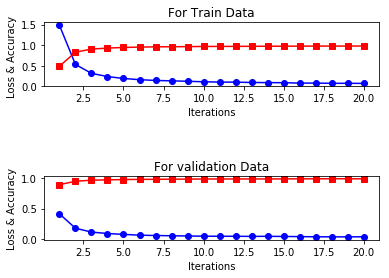

In [12]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1,len(loss_values)+1)
plt.clf()
plt.subplot(311)
plt.plot(epochs, loss_values,'bo-')
plt.plot(epochs, acc_values,'rs-')
plt.xlabel('Iterations')
plt.ylabel('Loss & Accuracy ')
plt.title("For Train Data")

plt.subplot(313)
plt.plot(epochs, val_loss_values,'bo-')
plt.plot(epochs, val_acc_values,'rs-')
plt.xlabel('Iterations')
plt.ylabel('Loss & Accuracy')
plt.title("For validation Data")

plt.show()